In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#import qlib
import subprocess
import os
import vectorbt as vbt
import pandas_ta as ta

import warnings
warnings.filterwarnings("ignore")


#qlib_root = r"E:\thunder download"
#os.chdir(qlib_root)

qlib_root = r"/Users/yutongdai/Downloads"
os.chdir(qlib_root)

In [11]:
qlib_root = r"E:\thunder download"
os.chdir(qlib_root)
etf_symbols = []
stock_symbols = []

with open("nasdaqtraded.txt", "r") as f:
    for line in f:
        if line.startswith("Nasdaq Traded") or not line.strip():
            continue

        parts = line.strip().split("|")
        if len(parts) < 7:
            continue

        traded_flag = parts[0]
        symbol = parts[1]
        is_etf = parts[5]

        if traded_flag != "Y":
            continue

        # 剔除非法符号和衍生后缀
        if any(substr in symbol for substr in ["$", "*", "=", "+", ".U", ".W", ".R", ".WS"]):
            continue

        if is_etf == "Y":
            etf_symbols.append(symbol)
        else:
            stock_symbols.append(symbol)

# 去重并排序
etf_symbols = sorted(set(etf_symbols))
stock_symbols = sorted(set(stock_symbols))

# 保存文件
with open("E:/data/qlib_data/test_us/us_etf_symbols.txt", "w") as f:
    for s in etf_symbols:
        f.write(s + "\n")

with open("E:/data/qlib_data/test_us/us_stock_symbols.txt", "w") as f:
    for s in stock_symbols:
        f.write(s + "\n")



In [ ]:
# Cell 1: 切到 qlib 根目录
import os
qlib_root = r"E:\thunder download\qlib"
os.chdir(qlib_root)

# Cell 2: 下载美股日线（测试2010版）
#!python scripts/get_data.py qlib_data --target_dir "E:/data/qlib_data/us_data" --region us --interval 1d
#这个能跑 原始下载from yahoo 完整版
#!python scripts/data_collector/yahoo/collector.py download_data --source_dir E:/data/qlib_data/test_us/source --region US --interval 1d --start 2000-01-01 --end 2025-07-21 --delay 0.4 
#标准化
#!python scripts/data_collector/yahoo/collector.py normalize_data --source_dir E:/data/qlib_data/us_data/source --normalize_dir E:/data/qlib_data/us_data/normalize --region US
#转储数据
#!python scripts/dump_bin.py dump_all --csv_path E:/data/qlib_data/us_data/normalize --qlib_dir E:/data/qlib_data/us_data/US_data
#输出spy列表
#!python collector.py --index_name SP500 --qlib_dir ~/.qlib/qlib_data/us_data --method parse_instruments
#更新数据
#!python scripts/data_collector/yahoo/collector.py update_data_to_bin --qlib_data_1d_dir E:/data/qlib_data/us_data/US_data --end_date 2025-07-18 --region US --delay 0.4

In [ ]:
qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region="us")
df = D.features(D.instruments("all"), ["$close"], freq="day")

## https://qlib.readthedocs.io/en/latest/start/getdata.html

## 新框架测试
# covered call 优化版信号识别模型

In [6]:
# Cell 4: 初始化 Qlib 验证
import qlib
from qlib.config import REG_US
from qlib.data import D
qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region=REG_US)
instruments = ['NK225MINI']

[23640:MainThread](2025-08-05 21:07:36,031) INFO - qlib.Initialization - [config.py:420] - default_conf: client.
[23640:MainThread](2025-08-05 21:07:38,121) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[23640:MainThread](2025-08-05 21:07:38,122) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('E:/data/qlib_data/us_data/US_data')}


In [ ]:
df = D.features(
    instruments=instruments,
    fields=["$open", "$high", "$low", "$close", "$volume"],
    start_time="2007-01-01",
    end_time="2025-7-28",
    freq="day"
)

In [3]:
qlib_root = r"/Users/yutongdai/Downloads"
os.chdir(qlib_root)

In [6]:
import pandas as pd

# 1. 读取Excel文件中的「終日日足」Sheet
file_path = "N225minif_2025.xlsx"   # ← 你的实际文件名
sheet_name = "終日日足"

# 2. 读取数据
df = pd.read_excel(file_path, sheet_name=sheet_name)

# 3. 字段名规范化（假设原始字段名为：日付、始値、高値、安値、終値、出来高）
df = df.rename(columns={
    "日付": "datetime",      # 日期
    "始値": "$open",         # 开盘价
    "高値": "$high",         # 最高价
    "安値": "$low",          # 最低价
    "終値": "$close",        # 收盘价
    "出来高": "$volume"      # 成交量
})

# 4. 转换日期格式，并按时间排序
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").set_index("datetime")

# 5. 保留标准Qlib格式的五列
qlib_df = df[["$open", "$high", "$low", "$close", "$volume"]].copy()

print(qlib_df.head())


            $open  $high   $low  $close  $volume
datetime                                        
2006-07-18  14680  14715  14400   14400    22345
2006-07-19  14500  14650  14465   14560    20646
2006-07-20  14860  14975  14780   14975    17398
2006-07-21  14840  14875  14790   14820    14689
2006-07-24  14685  14870  14560   14775    22641


In [ ]:
df = qlib_df
# Step 3: Generate simple technical indicators using pandas_ta
df["SMA_5"] = ta.sma(df["$close"], length=5)
df["SMA_20"] = ta.sma(df["$close"], length=20)
df["ROC_5"] = ta.roc(df["$close"], length=5)

# Step 4: Define signal: SMA_5 > SMA_20 and ROC_5 > 0
signal = (df["SMA_5"] > df["SMA_20"]) & (df["ROC_5"] > 0)

# Step 5: Set entry and exit
entries = signal
exits = signal.shift(7).fillna(False)  # Exit after 7 days

# Step 6: Run portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df["$close"],
    entries=entries,
    exits=exits,
    size=1.0,
    direction="longonly",
    fees=0.0,
    slippage=0.0
)

# Step 7: Collect stats
stats = portfolio.stats()

C:\Users\602599140\AppData\Local\Temp\ipykernel_23640\803312496.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  exits = signal.shift(7).fillna(False)  # Exit after 7 days
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
C:\Users\602599140\AppData\Roaming\Python\Python312\site-packages\vectorbt\generic\stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
#因子计算框架


def compute_all_factors(df: pd.DataFrame) -> pd.DataFrame:
    """
    输入 df，要求包含 columns: $open, $high, $low, $close, $volume
    返回一个新的 DataFrame，附加了各类常用技术因子。
    """
    df = df.copy()
    close = df["$close"]
    high = df["$high"]
    low = df["$low"]
    volume = df["$volume"]
    
    # 1. 动量因子（ROC）
    for length in [1, 3, 5, 8, 20]:
        df[f"ROC_{length}"] = ta.roc(close, length=length)
    
    # 2. 均线因子（MA）
    for length in [5, 10, 20, 50, 60]:
        df[f"MA_{length}"] = ta.sma(close, length=length)
    
    # 3. 超买超卖（RSI）
    for length in [14, 28]:
        df[f"RSI_{length}"] = ta.rsi(close, length=length)
    
    # 4. 趋势强度（ADX, +DI, -DI）
    adx = ta.adx(high, low, close, length=14)
    df["ADX_14"] = adx["ADX_14"]
    df["+DI_14"] = adx["DMP_14"]
    df["-DI_14"] = adx["DMN_14"]
    
    # 5. 波动率（ATR & BB 宽度）
    df["ATR_14"] = ta.atr(high, low, close, length=14)
    bb = ta.bbands(close, length=20, std=2)
    # 按位置提取：第0列=lower, 第1=middle, 第2=upper （具体顺序请根据你的 pandas_ta 版本确认）
    # 这里以 [lower, middle, upper] 顺序做示例，若与你版本相反，请调整
    df["BB_lower"]  = bb.iloc[:, 0]
    df["BB_middle"] = bb.iloc[:, 1]
    df["BB_upper"]  = bb.iloc[:, 2]
    df["BB_width"]  = (df["BB_upper"] - df["BB_lower"]) / df["BB_middle"]
    
    # 6. 量能因子（OBV & 5日斜率）
    df["OBV"]        = ta.obv(close, volume)
    df["OBV_slope"]  = df["OBV"].diff(5)
    
    # 7. 价量结合（VWAP_20）
    # 20日成交量加权平均价（近似）
    df["VWAP_20"] = (close * volume).rolling(20).sum() / volume.rolling(20).sum()
    
    # 8. KDJ（随机指标）
    stoch = ta.stoch(high, low, close, k=14, d=3, smooth_k=3)
    df["KDJ_K"] = stoch.iloc[:, 0]
    df["KDJ_D"] = stoch.iloc[:, 1]
    df["KDJ_J"] = 3 * df["KDJ_K"] - 2 * df["KDJ_D"]
    
    # 9. MACD
    macd = ta.macd(close, fast=12, slow=26, signal=9)
    df["MACD"]        = macd.iloc[:, 0]
    df["MACD_signal"] = macd.iloc[:, 1]
    df["MACD_hist"]   = macd.iloc[:, 2]
    
    # 丢弃前面因子计算产生的 NaN
    df_factors = df.dropna()
    return df_factors

# 使用示例
# df_raw 是你的終日日足 DataFrame
# df_factors = compute_all_factors(df_raw)
# print(df_factors.head())


#回测框架封装
def analyze_signal(
    df: pd.DataFrame,
    signal: pd.Series,
    horizon: int = 7,
    stop_loss_ratio: float = -0.02,
    plot: bool = True
) -> pd.DataFrame:
    """
    对给定的 signal 执行未来 horizon 天的行为分析（止损、下跌概率、回撤等）。

    参数
    ----
    df : pd.DataFrame
        包含 "$close"、"$low" 等标准 Qlib 列的 DataFrame，索引为日期。
    signal : pd.Series
        布尔 Series，指明哪些日期触发信号（与 df 对齐）。
    horizon : int
        回测窗口大小（未来多少天）。
    stop_loss_ratio : float
        止损阈值（如 -0.02 表示 2% 下跌触发）。
    plot : bool
        是否画出 7d_return 和 max_drawdown 的分布图。

    返回
    ----
    res_df : pd.DataFrame
        包含每次信号的回测结果，字段包括：
        - entry_date
        - exit_date
        - 7d_return
        - max_drawdown
        - stop_loss_hit
        - stop_loss_date
        - ended_down
        - success
    """
    entry_dates = df.index[signal.fillna(False)]
    results = []
    next_entry_idx = 0

    for dt in entry_dates:
        if dt not in df.index:
            continue
        entry_idx = df.index.get_loc(dt)
        if entry_idx < next_entry_idx:
            continue

        future = df.iloc[entry_idx+1 : entry_idx+1+horizon]
        if len(future) < horizon:
            continue

        entry_price = df.loc[dt, "$close"]
        end_price   = future["$close"].iloc[-1]
        min_price   = future["$low"].min()

        # 止损触发判断（盘中最低价）
        stop_loss_hit = False
        stop_loss_date = None
        for t, row in future.iterrows():
            if (row["$low"] - entry_price) / entry_price < stop_loss_ratio:
                stop_loss_hit = True
                stop_loss_date = t
                break

        ret_n   = (end_price - entry_price) / entry_price
        drawdown = (min_price - entry_price) / entry_price
        ended_down = ret_n < 0
        success    = not stop_loss_hit

        exit_date = stop_loss_date if stop_loss_hit else future.index[-1]

        results.append({
            "entry_date":    dt,
            "exit_date":     exit_date,
            "7d_return":     ret_n,
            "max_drawdown":  drawdown,
            "stop_loss_hit": stop_loss_hit,
            "stop_loss_date": stop_loss_date,
            "ended_down":    ended_down,
            "success":       success,
        })

        next_entry_idx = entry_idx + horizon

    res_df = pd.DataFrame(results)
    if res_df.empty:
        print("⚠️ 无有效信号触发。")
        return res_df

    # 打印统计
    total = len(res_df)
    avg_ret = res_df["7d_return"].mean()
    down_rate = res_df["ended_down"].mean()
    sl_rate = res_df["stop_loss_hit"].mean()
    avg_dd = res_df["max_drawdown"].mean()

    print("🔍 行为分析统计结果：")
    print(f"总信号触发次数：{total}")
    print(f"平均未来{horizon}日收益：{avg_ret:.2%}")
    print(f"7日下跌概率：{down_rate:.1%}")
    print(f"止损触发概率（{stop_loss_ratio:.1%}）：{sl_rate:.1%}")
    print(f"平均最大回撤：{avg_dd:.2%}")

    # 可视化
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        res_df["7d_return"].hist(bins=30, ax=axes[0])
        axes[0].set_title(f"{horizon}日收益分布")
        res_df["max_drawdown"].hist(bins=30, ax=axes[1])
        axes[1].set_title("最大回撤分布")
        plt.suptitle("信号行为分析")
        plt.tight_layout()
        plt.show()

    return res_df


In [25]:
df_factor = compute_all_factors(qlib_df)

In [ ]:

import itertools
import pandas as pd

# 你之前计算好的因子 DataFrame
df = df_factor.copy()  # 包含 ROC_1/8/20, MA_50/60/20, RSI_14, OBV, OBV_slope

# 1. 定义因子类
factor_classes = {
    "ROC": [
        ("ROC_1>0",  lambda d: d["ROC_1"] > 0),
        ("ROC_3>0",  lambda d: d["ROC_3"] > 0),
        ("ROC_5>0",  lambda d: d["ROC_5"] > 0),
        ("ROC_8>0",  lambda d: d["ROC_8"] > 0),
    ],
    "MA": [
        ("Close>MA50", lambda d: d["$close"] > d["MA_50"]),
        ("MA20↑",      lambda d: d["MA_20"].diff() > 0),
        ("MA10↑",      lambda d: d["MA_10"].diff() > 0),
        ("Close>MA20", lambda d: d["$close"] > d["MA_20"]),
    ],
    # —— 3. 超买超卖类（RSI, Stochastic RSI） —— 
    "RSI": [
        ("RSI14<30",     lambda d: d["RSI_14"] < 30),              # 超卖区，可反弹 
        ("|RSI14-50|<10",lambda d: (d["RSI_14"] - 50).abs() < 15), # 中性盘整
    ],

    # —— 4. 趋势强度类（ADX & DI） —— 
    "ADX": [
        ("ADX14<20",     lambda d: d["ADX_14"] < 20),             # 趋势弱/盘整
        ("ADX14>25",     lambda d: d["ADX_14"] > 25),             # 趋势强
        ("+DI>−DI",      lambda d: d["+DI_14"] > d["-DI_14"]),    # 多头占优
        ("−DI>+DI",      lambda d: d["-DI_14"] > d["+DI_14"]),    # 空头占优
    ],

    # —— 5. 波动率类（ATR & BB 宽度） —— 
    "Volatility": [
        ("ATR14<ATR50",  lambda d: d["ATR_14"] < d["ATR_14"].rolling(50).mean()),    # 低波动
        ("ATR14>ATR50",  lambda d: d["ATR_14"] > d["ATR_14"].rolling(50).mean()),    # 高波动
        ("BBW<0.05",     lambda d: d["BB_width"] < 0.05),                           # 布林带收窄
        ("BBW>0.1",      lambda d: d["BB_width"] > 0.1),                            # 布林带发散
    ],

    # —— 6. 量能类（OBV & Volume） —— 
    "Volume": [
        ("OBV↑",         lambda d: d["OBV_slope"] > 0),                            # OBV 上升
        ("OBV>MA20",     lambda d: d["OBV"] > d["OBV"].rolling(20).mean()),         # OBV 强于自身均线
        ("Vol>Vol20",    lambda d: d["$volume"] > d["$volume"].rolling(20).mean()),# 成交量放大
        ("Vol<Vol20",    lambda d: d["$volume"] < d["$volume"].rolling(20).mean()),# 成交量缩小
    ],

    # —— 7. 价量结合（VWAP） —— 
    "VWAP": [
        ("Close>VWAP20", lambda d: d["$close"] > d["VWAP_20"]),                     # 价格高于VWAP
        ("Close<VWAP20", lambda d: d["$close"] < d["VWAP_20"]),                     # 价格低于VWAP
    ],

    # —— 8. 随机指标（KDJ） —— 
    "KDJ": [
        ("%K>20",        lambda d: d["KDJ_K"] > 20),                               # %K 从超卖上升
        ("%D<80",        lambda d: d["KDJ_D"] < 80),                               # %D 未到超买
        ("J<100",        lambda d: d["KDJ_J"] < 100),                              # J 未极端
    ],

    # —— 9. 动量趋势（MACD） —— 
    "MACD": [
        ("DIF>DEA",      lambda d: d["MACD"] > d["MACD_signal"]),                  # DIF 线上穿DEA
        ("Hist>0",       lambda d: d["MACD_hist"] > 0),                            # 柱状图为正
        ("Hist<0",       lambda d: d["MACD_hist"] < 0),                            # 柱状图为负
    ],

    # —— 10. 其他常见（CCI, CMO, ROC斜率） —— 
    "Other": [
        ("CCI14>100",    lambda d: ta.cci(d["$high"], d["$low"], d["$close"], length=14) > 100),  # CCI 超买
        ("CMO>0",        lambda d: ta.cmo(d["$close"], length=14) > 0),                         # Chande 动量正
        ("ROC8↑",        lambda d: d["ROC_8"].diff() > 0),                                      # 8日动量斜率正
    ],
}

# 2. 枚举 2、3、4 类的所有组合
class_combos = []
for r in [2, 3, 4]:
    class_combos += list(itertools.combinations(factor_classes.keys(), r))

results = []
horizon = 10
stop_loss_ratio = -0.025

# 3. 对每个类组合，选 1 或 2 个因子并拼 signal
for classes in class_combos:
    # 每个类内部选 1 或 2 个
    choices = []
    for cls in classes:
        opts = factor_classes[cls]
        c1 = list(itertools.combinations(opts, 1))
        c2 = list(itertools.combinations(opts, 2))
        choices.append(c1 + c2)

    # 笛卡尔积，遍历所有具体因子子集
    for selected in itertools.product(*choices):
        flat = [item for group in selected for item in group]
        names = [name for name, _ in flat]

        # 构造 signal
        sig = pd.Series(True, index=df.index)
        for _, fn in flat:
            sig &= fn(df)

        # 跳过触发次数过少的信号
        if sig.sum() < 10:
            continue

        # 调用回测分析
        res = analyze_signal(df, sig, horizon=horizon, stop_loss_ratio=stop_loss_ratio, plot=False)
        if res.empty:
            continue

        results.append({
            "combination": " & ".join(names),
            "trades":      len(res),
            "down_rate":   res["ended_down"].mean(),
            "stop_rate":   res["stop_loss_hit"].mean(),
        })

# 4. 汇总并显示
res_df = pd.DataFrame(results).sort_values(["down_rate", "stop_rate"]).reset_index(drop=True)
print(res_df.head(20))


SyntaxError: incomplete input (3655196587.py, line 1)

In [67]:
res_df = pd.read_csv("factor_analysis_results.csv")
filtered = res_df[
    (res_df["trades"] >= 95) &
    (res_df["down_rate"] < 0.42) &
    (res_df["stop_rate"] < 0.42)
].reset_index(drop=True)

In [63]:
filtered

,combination,trades,down_rate,stop_rate
0,MA10↑ & −DI>+DI & Vol>Vol20 & %K>20 & %D<80,87,0.275862,0.402299
1,ROC_3>0 & ROC_5>0 & MA20↑ & Close>MA20 & ATR14...,83,0.277108,0.301205
2,ROC_3>0 & ROC_5>0 & MA20↑ & Close>MA20 & ATR14...,83,0.277108,0.301205
3,ROC_3>0 & ROC_5>0 & MA20↑ & ATR14>ATR50 & %D<80,89,0.280899,0.314607
4,ROC_3>0 & ROC_5>0 & MA20↑ & ATR14>ATR50 & %K>2...,89,0.280899,0.314607
...,...,...,...,...
11784,Close>MA50 & MA20↑ & |RSI14-50|<10 & OBV↑ & Vo...,181,0.419890,0.397790
11785,ROC_1>0 & ROC_8>0 & Close>MA50 & MA10↑ & OBV>M...,181,0.419890,0.414365
11786,ROC_1>0 & ROC_8>0 & OBV↑ & Vol>Vol20 & Close>V...,181,0.419890,0.419890
11787,ROC_1>0 & ROC_8>0 & OBV↑ & Vol>Vol20 & Close>V...,181,0.419890,0.419890


In [68]:
filtered.to_csv("factor_analysis_results_95.csv", index=False)

🔍 行为分析统计结果：
总信号触发次数：87
平均未来10日收益：0.93%
7日下跌概率：27.6%
止损触发概率（-2.5%）：40.2%
平均最大回撤：-2.69%


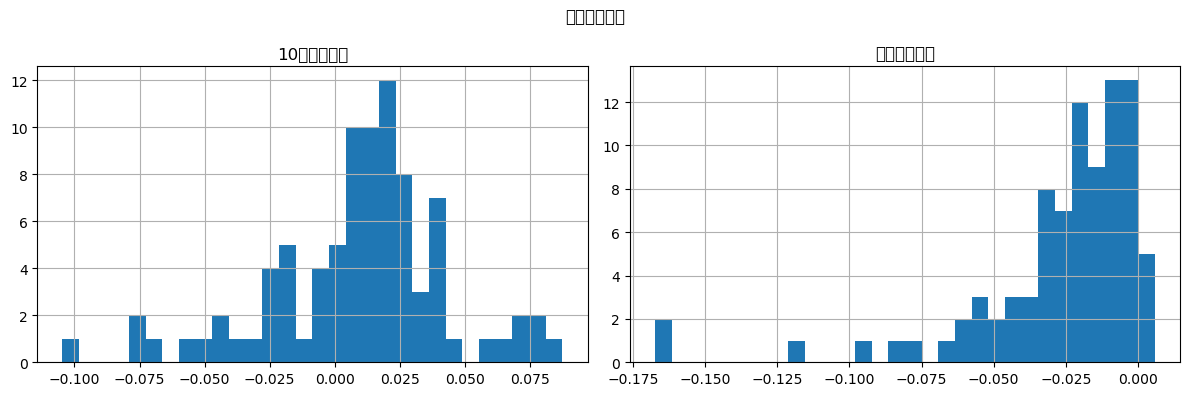

In [65]:
df = df_factor
# 假设 df 中包含 $close, $volume 等

# -----------信号逻辑：未来更可能“横盘或缓涨”-----------
'''
signal = (
    (df["ROC_8"] > 0) &              # 中期动量偏强
    (df["ROC_1"] > 0) &             # 短期没下跌
    (abs(df["RSI_14"] - 50) < 10) &    # RSI靠近中性，表明盘整可能
    (df["$close"] > df["MA50"]) & # 长期趋势
    (df["MA20"].diff() > 0)& #MA20斜率向上
    (df["OBV_slope"] > 0)
)
'''
signal = (
    (df["MA_10"].diff() > 0)                                  # 10日均线斜率向上
    & (df["-DI_14"] > df["+DI_14"])                           # 空头方向指标大于多头指标（空头占优）
    & (df["$volume"] > df["$volume"].rolling(20).mean())      # 日成交量大于20日均量
    & (df["KDJ_K"] > 20)                                      # %K 从超卖区上升
    & (df["KDJ_D"] < 80)                                      # %D 未到超买区
)



#----------------------
# 3. 确定每次信号触发的日期和入场价格
entry_dates = df.index[signal]
entry_prices = df["$close"].loc[entry_dates]

# 4. 设置分析参数
horizon = 10  # 回测窗口
stop_loss_ratio = -0.025  # 止损阈值（如 -0.03 表示 -3%）

# 3. 调用封装函数
res_df = analyze_signal(
    df,
    signal=signal,
    horizon=horizon,
    stop_loss_ratio=stop_loss_ratio,
    plot=True
)

# 7. 可视化
import matplotlib.pyplot as plt

#res_df[["7d_return", "max_drawdown"]].hist(bins=30, figsize=(10, 4))
#plt.suptitle("行为信号未来7日表现")
#plt.show()

In [66]:
import plotly.graph_objects as go

# ✅ 复制 df 以防污染
df_plot = df.copy()

# 提取各类日期
entry_dates = res_df["entry_date"]
stop_loss_dates = res_df.loc[res_df["stop_loss_hit"], "stop_loss_date"].dropna()
success_dates = res_df.loc[~res_df["stop_loss_hit"], "exit_date"].dropna()

# 主图：收盘价曲线
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot["$close"],
    mode='lines',
    name='Close Price',
    line=dict(color='lightgray')
))

# ✅ 开仓点：绿色圆圈
fig.add_trace(go.Scatter(
    x=entry_dates,
    y=df_plot.loc[entry_dates, "$close"],
    mode='markers',
    name='Entry Signal',
    marker=dict(color='green', size=13, symbol='circle')
))

# ❌ 止损点：红色叉
fig.add_trace(go.Scatter(
    x=stop_loss_dates,
    y=df_plot.loc[stop_loss_dates, "$close"],
    mode='markers',
    name='Stop-Loss',
    marker=dict(color='red', size=10, symbol='x')
))

# ✅ 成功出场点：蓝色菱形
fig.add_trace(go.Scatter(
    x=success_dates,
    y=df_plot.loc[success_dates, "$close"],
    mode='markers',
    name='Exit (Success)',
    marker=dict(color='blue', size=8, symbol='diamond')
))

# 美化图表
fig.update_layout(
    title="📊 NK225MINI 信号行为分析图（Covered Call 策略）",
    xaxis_title="Date",
    yaxis_title="Close Price",
    height=600,
    legend=dict(x=0.01, y=0.99),
)

fig.show()


In [11]:
stats

Start                         (NK225MINI, 2009-05-01 00:00:00)
End                           (NK225MINI, 2025-07-28 00:00:00)
Period                                                    4006
Start Value                                              100.0
End Value                                           146.123562
Total Return [%]                                     46.123562
Benchmark Return [%]                                352.794695
Max Gross Exposure [%]                                   100.0
Total Fees Paid                                            0.0
Max Drawdown [%]                                     30.040831
Max Drawdown Duration                                   1949.0
Total Trades                                               187
Total Closed Trades                                        186
Total Open Trades                                            1
Open Trade PnL                                        3.482534
Win Rate [%]                                         44

In [ ]:
#alpha 适用于ml的输入特征无法相互比较
df = Alpha158(
    instruments=["NK225MINI"],
    start_time="2010-01-01",
    end_time="2025-07-18",
    fit_start_time="2010-01-01",
    fit_end_time="2025-07-18",
    infer_processors=[]
).fetch()

[3076:MainThread](2025-08-04 22:01:12,912) INFO - qlib.timer - [log.py:127] - Time cost: 0.052s | Loading data Done
[3076:MainThread](2025-08-04 22:01:12,919) INFO - qlib.timer - [log.py:127] - Time cost: 0.002s | DropnaLabel Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 3.965s | CSZScoreNorm Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 3.972s | fit & process data Done
[3076:MainThread](2025-08-04 22:01:16,884) INFO - qlib.timer - [log.py:127] - Time cost: 4.025s | Init data Done


In [ ]:
df

,,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
datetime,instrument,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NK225MINI,0.004247,0.010382,0.409091,0.005663,0.545455,0.000472,0.045455,-0.000944,-0.090909,0.995771,...,0.576720,0.565180,0.521629,0.503010,-0.089757,-0.153440,-0.130360,-0.043258,-0.006020,0.002338
2010-01-05,NK225MINI,-0.007885,0.012987,-0.607143,0.001855,0.142857,0.003247,0.250000,-0.006494,-0.500000,1.007948,...,0.414241,0.532436,0.484342,0.472519,0.760401,0.171519,-0.064873,0.031316,0.054962,-0.002332
2010-01-06,NK225MINI,0.000000,0.010728,0.000000,0.005131,0.478261,0.005597,0.521739,0.000466,0.043478,1.000000,...,0.481314,0.514820,0.513796,0.486732,0.393264,0.037372,-0.029640,-0.027592,0.026537,0.011220
2010-01-07,NK225MINI,-0.004190,0.013035,-0.321429,0.003259,0.250000,0.005587,0.428571,-0.001862,-0.142857,1.004208,...,0.358198,0.510624,0.499639,0.490667,0.216969,0.283604,-0.021247,0.000723,0.018665,0.008322
2010-01-08,NK225MINI,0.004178,0.014856,0.281250,0.001393,0.093750,0.009285,0.625000,0.012071,0.812500,0.995839,...,0.375573,0.453122,0.473132,0.482583,0.333625,0.248854,0.093757,0.053737,0.034833,-0.016506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-14,NK225MINI,0.001270,0.008130,0.156250,0.004954,0.609375,0.001905,0.234375,-0.001778,-0.218750,0.998731,...,0.645186,0.515638,0.500549,0.500889,0.066005,-0.290371,-0.031276,-0.001098,-0.001777,-0.001639
2025-07-15,NK225MINI,0.002528,0.007711,0.327869,0.000506,0.065574,0.004677,0.606557,0.006700,0.868852,0.997478,...,0.571477,0.477507,0.486521,0.496068,-0.011319,-0.142955,0.044987,0.026959,0.007863,0.008714
2025-07-16,NK225MINI,-0.000253,0.010227,-0.024691,0.007955,0.777778,0.002020,0.197531,-0.006187,-0.604938,1.000253,...,0.539630,0.474713,0.477277,0.499745,0.394400,-0.079259,0.050575,0.045446,0.000509,-0.002504


In [34]:
df.to_csv("nk225mini_alpha159.csv")

In [45]:
import qlib
from qlib.data import D
from qlib.config import REG_US
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qlib.contrib.data.handler import Alpha158

# 初始化 Qlib
#qlib.init(provider_uri="E:/data/qlib_data/us_data/US_data", region=REG_US)

# ---------------------
# 参数设置
instruments = ['NK225MINI']
start_time = "2007-01-01"
end_time = "2025-07-18"
forecast_horizon = 5  # 未来几天
threshold_return = -0.01  # 定义"下跌"的阈值（如回撤超过1%）

# ---------------------
# 使用 Alpha158 生成因子数据
df = Alpha158(
    instruments=["NK225MINI"],
    start_time="2010-01-01",
    end_time="2025-07-18",
    #fit_start_time="2010-01-01",
    #fit_end_time="2025-07-18",
    infer_processors=[],#标准化for ml\
    learn_processors=[],
).fetch()
#df = df.dropna()

# 因子命名需精确匹配 Alpha158 输出，如 "MA5", "MA20", "ROC5", "STD20"
#factor_cols = ["MA5", "MA20", "ROC5", "STD20", "LABEL0"]
#df = df.dropna(subset=factor_cols)  # 避免因子 NaN 导致丢行



[3076:MainThread](2025-08-04 23:10:27,368) INFO - qlib.timer - [log.py:127] - Time cost: 0.060s | Loading data Done
[3076:MainThread](2025-08-04 23:10:27,368) INFO - qlib.timer - [log.py:127] - Time cost: 0.000s | fit & process data Done
[3076:MainThread](2025-08-04 23:10:27,370) INFO - qlib.timer - [log.py:127] - Time cost: 0.062s | Init data Done


In [46]:
df

,,KMID,KLEN,KMID2,KUP,KUP2,KLOW,KLOW2,KSFT,KSFT2,OPEN0,...,VSUMN10,VSUMN20,VSUMN30,VSUMN60,VSUMD5,VSUMD10,VSUMD20,VSUMD30,VSUMD60,LABEL0
datetime,instrument,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NK225MINI,0.004247,0.010382,0.409091,0.005663,0.545455,0.000472,0.045455,-0.000944,-0.090909,0.995771,...,0.576720,0.565180,0.521629,0.503010,-0.089757,-0.153440,-0.130360,-0.043258,-0.006020,0.002338
2010-01-05,NK225MINI,-0.007885,0.012987,-0.607143,0.001855,0.142857,0.003247,0.250000,-0.006494,-0.500000,1.007948,...,0.414241,0.532436,0.484342,0.472519,0.760401,0.171519,-0.064873,0.031316,0.054962,-0.002332
2010-01-06,NK225MINI,0.000000,0.010728,0.000000,0.005131,0.478261,0.005597,0.521739,0.000466,0.043478,1.000000,...,0.481314,0.514820,0.513796,0.486732,0.393264,0.037372,-0.029640,-0.027592,0.026537,0.011220
2010-01-07,NK225MINI,-0.004190,0.013035,-0.321429,0.003259,0.250000,0.005587,0.428571,-0.001862,-0.142857,1.004208,...,0.358198,0.510624,0.499639,0.490667,0.216969,0.283604,-0.021247,0.000723,0.018665,0.008322
2010-01-08,NK225MINI,0.004178,0.014856,0.281250,0.001393,0.093750,0.009285,0.625000,0.012071,0.812500,0.995839,...,0.375573,0.453122,0.473132,0.482583,0.333625,0.248854,0.093757,0.053737,0.034833,-0.016506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-14,NK225MINI,0.001270,0.008130,0.156250,0.004954,0.609375,0.001905,0.234375,-0.001778,-0.218750,0.998731,...,0.645186,0.515638,0.500549,0.500889,0.066005,-0.290371,-0.031276,-0.001098,-0.001777,-0.001639
2025-07-15,NK225MINI,0.002528,0.007711,0.327869,0.000506,0.065574,0.004677,0.606557,0.006700,0.868852,0.997478,...,0.571477,0.477507,0.486521,0.496068,-0.011319,-0.142955,0.044987,0.026959,0.007863,0.008714
2025-07-16,NK225MINI,-0.000253,0.010227,-0.024691,0.007955,0.777778,0.002020,0.197531,-0.006187,-0.604938,1.000253,...,0.539630,0.474713,0.477277,0.499745,0.394400,-0.079259,0.050575,0.045446,0.000509,-0.002504


In [38]:
# 参数设置
forecast_horizon = 7
stop_loss_ratio = -0.03  # 例如 -3%
threshold_dd = stop_loss_ratio

# 策略信号（示例：均线+动量）
signal = (df["MA5"] > df["MA20"]) & (df["ROC5"] > 0)
signal_df = df[signal].copy()

# 收益与最大回撤（未来 horizon 日）
future_returns = []
hit_stop_loss = []
max_drawdowns = []

close_series = df["CLOSE0"]
low_series = df["LOW0"] if "LOW0" in df.columns else None

for dt in signal_df.index:
    try:
        cur_price = close_series.loc[dt]
        future_prices = close_series.loc[dt:].iloc[1:forecast_horizon + 1]
        future_lows = low_series.loc[dt:].iloc[1:forecast_horizon + 1] if low_series is not None else None

        # 收益：末日价格 - 入场价
        ret = (future_prices[-1] - cur_price) / cur_price
        future_returns.append(ret)

        # 最大回撤 = 最低价 - 入场价
        if future_lows is not None:
            dd = (future_lows.min() - cur_price) / cur_price
            max_drawdowns.append(dd)
            hit_stop_loss.append(dd < stop_loss_ratio)  # 是否触发止损
        else:
            max_drawdowns.append(None)
            hit_stop_loss.append(None)
    except:
        continue

# -------------------
# 汇总结果
res_df = pd.DataFrame({
    "future_return": future_returns,
    "max_drawdown": max_drawdowns,
    "hit_stop": hit_stop_loss
}).dropna()

print("📊 策略统计结果：")
print(f"✅ 信号总触发次数：{len(res_df)}")
print(f"📈 平均未来{forecast_horizon}日收益：{res_df['future_return'].mean():.3%}")
print(f"✔️ 胜率（收益 > 0）：{(res_df['future_return'] > 0).mean():.1%}")
print(f"⛔ 触发止损（跌破 {stop_loss_ratio:.1%}）的概率：{res_df['hit_stop'].mean():.1%}")
print(f"📉 平均最大回撤：{res_df['max_drawdown'].mean():.2%}")

# 可视化（收益分布）
res_df["future_return"].hist(bins=30)
plt.title(f"未来{forecast_horizon}日收益分布")
plt.xlabel("Return")
plt.grid()
plt.show()

KeyError: 'CLOSE0'

,,$close,$MA_20,$MA_60,$RETURN_5
instrument,datetime,,,,
